In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [2]:
#scrape a single game shots. We will allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id: 17939


In [19]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [20]:
#get only the shotsData
strings = scripts[1].string

In [21]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [22]:
minute = []
xG = []
result = []
team = []
data_away = data['a']
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'minute':
            minute.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'minute':
            minute.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])

In [23]:
col_names = ['minute','xG','result','team']
df = pd.DataFrame([minute,xG,result,team],index=col_names)
df = df.T

In [24]:
df['xG'] = df['xG'].astype(float)
print(df)

   minute        xG       result                 team
0      22  0.053181    SavedShot  Paris Saint Germain
1      29  0.082275  MissedShots  Paris Saint Germain
2      39  0.309287  MissedShots  Paris Saint Germain
3      45  0.051625  MissedShots  Paris Saint Germain
4      54  0.066658    SavedShot  Paris Saint Germain
5      57  0.019712  BlockedShot  Paris Saint Germain
6      58  0.018783    SavedShot  Paris Saint Germain
7      59  0.426678  MissedShots  Paris Saint Germain
8      66  0.014278  MissedShots  Paris Saint Germain
9      68  0.053927  BlockedShot  Paris Saint Germain
10     69  0.086228  MissedShots  Paris Saint Germain
11     70  0.049238  MissedShots  Paris Saint Germain
12     72  0.096118  MissedShots  Paris Saint Germain
13     73  0.499429         Goal  Paris Saint Germain
14     77  0.059555    SavedShot  Paris Saint Germain
15     84  0.328548  MissedShots  Paris Saint Germain
16     87  0.094223         Goal  Paris Saint Germain
17      0  0.268005    Saved

In [25]:
#now that we have our dataframe set up, we are going to create some lists to plot the different xG values
#4 lists - home and away xg and minutes
#We start these with zero so our charts will start at 0
a_xG = [0]
h_xG= [0]
home=[data_home[0]['h_team']]
a_min = [0]
h_min = [0]
away=[data_home[0]['a_team']]


#this finds our team names from the dataframe. This will only work as long as both teams took a shot
hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]

for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
        away.append(data_home[0]['a_team'])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
        home.append(data_home[0]['h_team'])
        
#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

[0, '22', '29', '39', '45', '54', '57', '58', '59', '66', '68', '69', '70', '72', '73', '77', '84', '87']
[0, '0', '13', '13', '14', '30', '40', '46', '46', '56', '71', '83']


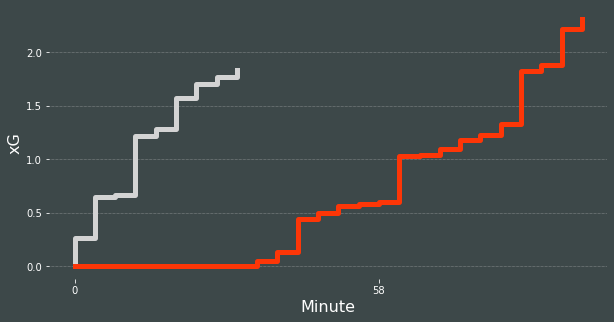

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,5))
fig.set_facecolor('#3d4849')
ax.patch.set_facecolor('#3d4849')

#set up our base layer
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

ax.grid(ls='dotted',lw=.5,color='lightgrey',axis='y',zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
plt.xticks([0,15,30,45,60,75,90])
plt.xlabel('Minute',fontname='Andale Mono',color='white',fontsize=16)
plt.ylabel('xG',fontname='Andale Mono',color='white',fontsize=16)
print(h_min)
print(a_min)
#plot the step graphs
ax.step(x=a_min,y=a_cumulative,color='#d3d3d3',label=ateam,linewidth=5,where='post')
ax.step(x=h_min,y=h_cumulative,color='#fd3607',label=ateam,linewidth=5,where='post')

In [27]:
xG = a_cumulative + h_cumulative
minute = a_min + h_min
teams = away + home

In [28]:
col_names = ['minute','xG','team']
df = pd.DataFrame([minute,xG,teams],index=col_names)
df = df.T
print(df)

   minute        xG                 team
0       0         0                Lille
1       0  0.268005                Lille
2      13  0.294457                Lille
3      13  0.647154                Lille
4      14  0.668987                Lille
5      30  1.215975                Lille
6      40  1.287158                Lille
7      46  1.419152                Lille
8      46  1.574452                Lille
9      56  1.706418                Lille
10     71  1.767515                Lille
11     83  1.833353                Lille
12      0         0  Paris Saint Germain
13     22  0.053181  Paris Saint Germain
14     29  0.135457  Paris Saint Germain
15     39  0.444743  Paris Saint Germain
16     45  0.496368  Paris Saint Germain
17     54  0.563026  Paris Saint Germain
18     57  0.582739  Paris Saint Germain
19     58  0.601522  Paris Saint Germain
20     59    1.0282  Paris Saint Germain
21     66  1.042478  Paris Saint Germain
22     68  1.096406  Paris Saint Germain
23     69  1.182

In [35]:
print(str(int(data_home[0]['season'])+1))
df.to_csv(r'../CSV/xG matchs/'+str(data_home[0]['season'])+'-'+str(int(data_home[0]['season']+1))+'/xG_'+str(data_home[0]['h_team'])+'-'+str(data_home[0]['a_team'])+'.csv', index = False)

2022


TypeError: can only concatenate str (not "int") to str

In [29]:
print(data)

{'h': [{'id': '439322', 'minute': '22', 'result': 'SavedShot', 'X': '0.8090000152587891', 'Y': '0.49700000762939456', 'xG': '0.053181473165750504', 'player': 'Ángel Di María', 'h_a': 'h', 'player_id': '3553', 'situation': 'OpenPlay', 'season': '2021', 'shotType': 'RightFoot', 'match_id': '17939', 'h_team': 'Paris Saint Germain', 'a_team': 'Lille', 'h_goals': '2', 'a_goals': '1', 'date': '2021-10-29 19:00:00', 'player_assisted': 'Lionel Messi', 'lastAction': 'Pass'}, {'id': '439323', 'minute': '29', 'result': 'MissedShots', 'X': '0.895', 'Y': '0.595999984741211', 'xG': '0.08227503299713135', 'player': 'Lionel Messi', 'h_a': 'h', 'player_id': '2097', 'situation': 'OpenPlay', 'season': '2021', 'shotType': 'LeftFoot', 'match_id': '17939', 'h_team': 'Paris Saint Germain', 'a_team': 'Lille', 'h_goals': '2', 'a_goals': '1', 'date': '2021-10-29 19:00:00', 'player_assisted': 'Ángel Di María', 'lastAction': 'Chipped'}, {'id': '439325', 'minute': '39', 'result': 'MissedShots', 'X': '0.96900001525